>[Prerequisites (downloading tensorflow_models and checkpoints)](#scrollTo=T_cETKXHDTXu)

>[Checkpoint based inference](#scrollTo=fxMe7_pkk_Vo)

>[Frozen inference](#scrollTo=PlwvpK3ElBk6)



# Prerequisites (downloading tensorflow_models and checkpoints)

In [0]:
!git clone https://github.com/tensorflow/models

Cloning into 'models'...
remote: Counting objects: 13504, done.
remote: Total 13504 (delta 2), reused 2 (delta 2), pack-reused 13501
Receiving objects: 100% (13504/13504), 422.07 MiB | 37.42 MiB/s, done.
Resolving deltas: 100% (7635/7635), done.
Checking out files: 100% (1946/1946), done.


In [0]:
from __future__ import print_function
from IPython import display 
checkpoint_name = 'mobilenet_v2_1.0_224' #@param
url = 'https://storage.googleapis.com/mobilenet_v2/checkpoints/' + checkpoint_name + '.tgz'
print('Downloading from ', url)
!wget {url}
print('Unpacking')
!tar -xvf {checkpoint_name}.tgz
checkpoint = checkpoint_name + '.ckpt'

display.clear_output()
print('Successfully downloaded checkpoint from ', url,
      '. It is available as', checkpoint)


Successfully downloaded the checkpoint. It is available as mobilenet_v2_1.0_224.ckpt


In [0]:
!wget https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG -O panda.jpg

--2018-03-19 18:43:29--  https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116068 (113K) [image/jpeg]
Saving to: ‘panda.jpg’

panda.jpg           100%[===================>] 113.35K  --.-KB/s    in 0.03s   

2018-03-19 18:43:30 (3.18 MB/s) - ‘panda.jpg’ saved [116068/116068]



In [0]:
# setup path
import sys
sys.path.append('/content/models/research/slim')

# Checkpoint based inference

In [0]:
import tensorflow as tf
from nets.mobilenet import mobilenet_v2

tf.reset_default_graph()

# For simplicity we just decode jpeg inside tensorflow.
# But one can provide any input obviously.
file_input = tf.placeholder(tf.string, ())

image = tf.image.decode_jpeg(tf.read_file(file_input))

images = tf.expand_dims(image, 0)
images = tf.cast(images, tf.float32) / 128.  - 1
images.set_shape((None, None, None, 3))
images = tf.image.resize_images(images, (224, 224))

# Note: arg_scope is optional for inference.
with tf.contrib.slim.arg_scope(mobilenet_v2.training_scope(is_training=False)):
  logits, endpoints = mobilenet_v2.mobilenet(images)
  
# Restore using exponential moving average since it produces (1.5-2%) higher 
# accuracy
ema = tf.train.ExponentialMovingAverage(0.999)
vars = ema.variables_to_restore()

saver = tf.train.Saver(vars)  

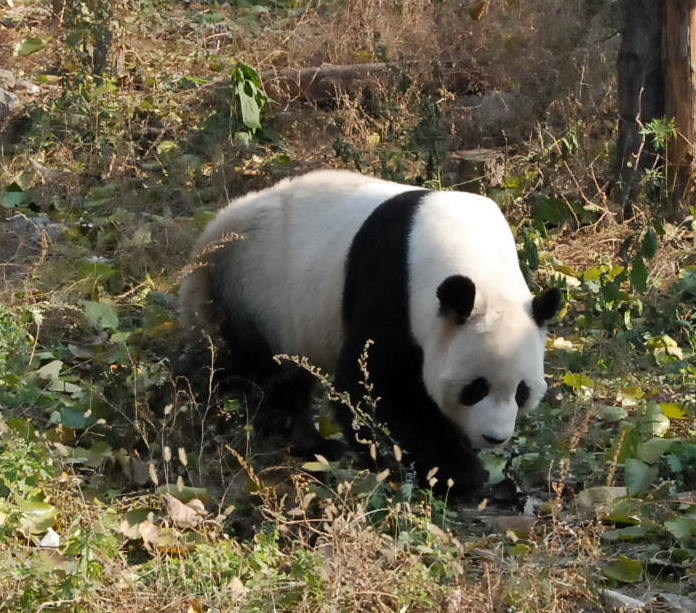

INFO:tensorflow:Restoring parameters from mobilenet_v2_1.0_224.ckpt
Top 1 prediction:  389 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca 0.90984344


In [0]:
from IPython import display
import pylab
from datasets import imagenet
import PIL
display.display(display.Image('panda.jpg'))

with tf.Session() as sess:
  saver.restore(sess,  checkpoint)
  x = endpoints['Predictions'].eval(feed_dict={file_input: 'panda.jpg'})
label_map = imagenet.create_readable_names_for_imagenet_labels()  
print("Top 1 prediction: ", x.argmax(),label_map[x.argmax()], x.max())


# Frozen inference

In [0]:
import numpy as np
img = np.array(PIL.Image.open('panda.jpg').resize((224, 224))).astype(np.float) / 128 - 1
gd = tf.GraphDef.FromString(open(checkpoint_name + '_frozen.pb', 'rb').read())
inp, predictions = tf.import_graph_def(gd,  return_elements = ['input:0', 'MobilenetV2/Predictions/Reshape_1:0'])

In [0]:
with tf.Session(graph=inp.graph):
  x = predictions.eval(feed_dict={inp: img.reshape(1, 224,224, 3)})

label_map = imagenet.create_readable_names_for_imagenet_labels()  
print("Top 1 Prediction: ", x.argmax(),label_map[x.argmax()], x.max())

Top 1 Prediction:  389 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca 0.9220208
